# Set Up

In [4]:
import gensim#For word2vec, etc
from gensim.models import ldaseqmodel

import lucem_illud_2020

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import scipy
import matplotlib
import matplotlib.pyplot as plt #For graphics
import wordcloud
import seaborn as sns #makes our plots look nicer

from sklearn.cluster import KMeans
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA


import nltk
from nltk.collocations import *

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import re
import string
import os #For looking through files
import os.path #For managing file paths

## Load Data

In [5]:
data = pd.read_pickle("data/coca_data_normalized.pkl")

In [6]:
data.genre.unique()

array(['MAG', 'SPOK', 'NEWS'], dtype=object)

In [7]:
#5-year periods
def get_period(year, startyr, endyr, n=5):
    period_start = []
    for i in range(startyr, endyr+1, n):
        period_start.append(i)
    for index, p in enumerate(period_start):
        if year >= p:
            period = index
            continue
        else:
            break
    return period  
    
data['period'] = data['year'].apply(lambda x: get_period(x, 1991, 2015, n=5) if x>=1991 else 0)

## Labelling Ideology

In [8]:
unique_sources = list(data.source.apply(lambda x: re.split("_|: | ", x)[0]).unique())
len(unique_sources)

109

In [9]:
# Write a function that let us conveniently label ideology: Left, Neutral, Right
media_ideology = {}

def label_ideology(media_title, ideology, media_ideology = media_ideology):
    media_ideology[media_title] = ideology

In [10]:
label_ideology('Money', 'Neutral')
label_ideology('MotherEarth', 'Neutral')
label_ideology('MotherJones', 'Left')
label_ideology('AmHeritage', 'Neutral')
label_ideology('AmSpect', 'Right')
label_ideology('Forbes', 'Right')
label_ideology('NatlReview', 'Right')
label_ideology('Newsweek', 'Left')
label_ideology('ScienceNews', 'Neutral')
label_ideology('Smithsonian', 'Neutral')
label_ideology('USNWR', 'Left')
label_ideology('WashMonth', 'Left')
label_ideology('ChangingTimes', 'Right')
label_ideology('HistoryToday', 'Neutral')
label_ideology('Omni', 'Neutral')
label_ideology('Wilderness', 'Neutral')
label_ideology('TIME', 'Left')
label_ideology('NatlParks', 'Neutral')
label_ideology('AmerArtist', 'Neutral')
label_ideology('RollingStone', 'Left')
label_ideology('Americas', 'Neutral')
label_ideology('SportsIll', 'Neutral')
label_ideology('Ms', 'Left')
label_ideology('PopScience', 'Neutral')
label_ideology('Futurist', 'Neutral')
label_ideology('HarpersMag', 'Left')
label_ideology('Fortune', 'Right')
label_ideology('USAToday', 'Left')
label_ideology('America', 'Left')
label_ideology('ChristCentury', 'Right')
label_ideology('People', 'Left')
label_ideology('Jet', 'Left')
label_ideology('Aging', 'Neutral')
label_ideology('Horticulture', 'Neutral')
label_ideology('NewRepublic', 'Left')
label_ideology('Conservation', 'Left')
label_ideology('NaturalHist', 'Neutral')
label_ideology('Atlantic', 'Left')
label_ideology('Inc.', 'Neutral')
label_ideology('ChildrenToday', 'Neutral')
label_ideology('Ebony', 'Left')
label_ideology('ConsumResrch', 'Neutral')
label_ideology('SatEvenPost', 'Neutral')
label_ideology('ChristToday', 'Right')
label_ideology('Backpacker', 'Neutral')
label_ideology('AmericanCraft', 'Neutral')
label_ideology('ArtAmerica', 'Neutral')
label_ideology('SportingNews', 'Neutral')
label_ideology('MensHealth', 'Neutral')
label_ideology('Antiques', 'Neutral')
label_ideology('Parenting', 'Neutral')
label_ideology('Essence', 'Neutral')
label_ideology('Environmental', 'Neutral')
label_ideology('USCatholic', 'Right')
label_ideology('MilitaryHist', 'Neutral')
label_ideology('PsychToday', 'Neutral')
label_ideology('Cosmopolitan', 'Left')
label_ideology('Redbook', 'Neutral')
label_ideology('Bazaar', 'Left')
label_ideology('ChildDigest', 'Neutral')
label_ideology('Bicycling', 'Neutral')
label_ideology('Shape', 'Neutral')
label_ideology('NatGeog', 'Neutral')
label_ideology('Entertainment', 'Neutral')
label_ideology('Astronomy', 'Neutral')
label_ideology('TownCountry', 'Neutral')
label_ideology('TotalHealth', 'Neutral')
label_ideology('Esquire', 'Left')
label_ideology('FieldStream', 'Neutral')
label_ideology('TechReview', 'Neutral')
label_ideology('CountryLiving', 'Neutral')
label_ideology('VegTimes', 'Neutral')
label_ideology('SouthernLiv', 'Neutral')
label_ideology('Skiing', 'Neutral')
label_ideology('ConsumRep', 'Neutral')
label_ideology('Sunset', 'Neutral')
label_ideology('HarpersBazaar', 'Neutral')
label_ideology('AmericanSpectator', 'Right')
label_ideology('GoodHousekeeping', 'Neutral')
label_ideology('PopMech', 'Neutral')
label_ideology('MHQTheQuarterly', 'Neutral')
label_ideology('TodaysParent', 'Neutral')
label_ideology('NationalGeographic', 'Neutral')
label_ideology('EEnvironmental', 'Neutral')
label_ideology('ParentingEarly', 'Neutral')
label_ideology('ABC', 'Left')
label_ideology('CNN', 'Left')
label_ideology('PBS', 'Left')
label_ideology('CBS', 'Left')
label_ideology('Ind', 'Left')
label_ideology('NPR', 'Left')
label_ideology('NBC', 'Left')
label_ideology('Fox', 'Right')
label_ideology('MSNBC', 'Left')
label_ideology('NYTimes', 'Left')
label_ideology('CSMonitor', 'Neutral')
label_ideology('AssocPress', 'Neutral')
label_ideology('WashPost', 'Left')
label_ideology('SanFranChron', 'Left')
label_ideology('Atlanta', 'Left') #Atlanta Journal Constitution
label_ideology('Houston', 'Left') #Houston Chronicle
label_ideology('Chicago', 'Left') #Chicago Sun-Times
label_ideology('Denver', 'Left') #Denver Post
label_ideology('GolfMag', 'Neutral')
label_ideology('NewStatesman', 'Left')
label_ideology('Austin', 'Left') #Austin American Statesman
label_ideology('STLouis', 'Left') #St Louis Post_Dispatch
label_ideology('Pittsburgh', 'Right') #Pittsburgh Post-Gazette
label_ideology('OrangeCR', 'Right') #Orange County Register

In [11]:
media_ideology

{'Money': 'Neutral',
 'MotherEarth': 'Neutral',
 'MotherJones': 'Left',
 'AmHeritage': 'Neutral',
 'AmSpect': 'Right',
 'Forbes': 'Right',
 'NatlReview': 'Right',
 'Newsweek': 'Left',
 'ScienceNews': 'Neutral',
 'Smithsonian': 'Neutral',
 'USNWR': 'Left',
 'WashMonth': 'Left',
 'ChangingTimes': 'Right',
 'HistoryToday': 'Neutral',
 'Omni': 'Neutral',
 'Wilderness': 'Neutral',
 'TIME': 'Left',
 'NatlParks': 'Neutral',
 'AmerArtist': 'Neutral',
 'RollingStone': 'Left',
 'Americas': 'Neutral',
 'SportsIll': 'Neutral',
 'Ms': 'Left',
 'PopScience': 'Neutral',
 'Futurist': 'Neutral',
 'HarpersMag': 'Left',
 'Fortune': 'Right',
 'USAToday': 'Left',
 'America': 'Left',
 'ChristCentury': 'Right',
 'People': 'Left',
 'Jet': 'Left',
 'Aging': 'Neutral',
 'Horticulture': 'Neutral',
 'NewRepublic': 'Left',
 'Conservation': 'Left',
 'NaturalHist': 'Neutral',
 'Atlantic': 'Left',
 'Inc.': 'Neutral',
 'ChildrenToday': 'Neutral',
 'Ebony': 'Left',
 'ConsumResrch': 'Neutral',
 'SatEvenPost': 'Neutral',

In [12]:
#add political leaning label
def add_ideology(x, media_ideology=media_ideology):
    try_split = re.split("_|: | ",x)
    if len(try_split)>1:
        x = try_split[0]
    if x in media_ideology:
        return media_ideology[x]
    else:
        print('{} does not exists'.format(x))

data["ideology"] = data['source'].apply(add_ideology)

In [13]:
data.groupby(['ideology','period']).size()

ideology  period
Left      0         890
          1         526
          2         548
          3         344
          4         420
Neutral   0         275
          1         165
          2         170
          3         185
          4         198
Right     0          57
          1          37
          2          48
          3          35
          4          94
dtype: int64

## Additional stopwords

In [14]:
names=[]
for word in data[data.genre=='SPOK']['text'].sum().split():
    if word.startswith('!') or word.endswith('#'):
        word = word.translate(str.maketrans('', '', string.punctuation))
        names.append(word)
names

['hughdowns',
 'announcer',
 'announcer',
 'announcer',
 'announcer',
 'announcer',
 'downs',
 'walters',
 'downs',
 'jarriel',
 'jarriel',
 'jarriel',
 'wells',
 'jarriel',
 'wells',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'downs',
 'jarriel',
 'jarriel',
 'franisse',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'jarriel',
 'downs',
 'downs',
 'downs',
 'jarriel',
 'downs',
 'jarriel',
 'downs',
 'walters',
 'resident',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 'stossel',
 '',
 '',
 'son',
 '',
 '',
 '',
 '',
 'stossel',
 'stossel',
 'stossel',
 'stosse

In [15]:
#Frequency Distribution
fdist = nltk.FreqDist([w for w in data['normalized_words'].sum()])
freq = pd.DataFrame.from_dict(fdist, orient='index', columns=['count'])
freq = freq.sort_values(by='count', ascending=False)
freq[:50]

,count
say,49565
people,36155
think,30895
go,28799
year,27061
know,26441
mr,25620
time,22330
come,21985
like,21222


In [16]:
# remove frequent common words, stop at child
stopwords = freq.index[:38]

In [17]:
# remove top common verbs
freqdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in data['normalized_words_POS'].sum())
topverbs = freqdist_POStoWord['VB'].most_common(50) # stop at protect
stopwords_verbs = [v for v,count in topverbs]

In [18]:
others=['qwq', 'voice-over', 'voiceover','>','+', 'end', 'video', 'clip', 'morning', 'tonight', 'news', 'ms', 
        'mrs', 'mr','s','voice', 'thank', 'watching', 'have', 'good', 'evening', 'weekend', 'night', 'yes', 
        'lot', 'long']
# get rid of other words that are not relevant

stopwords_all=set(stopwords).union(set(stopwords_verbs),set(others), set(names))

#  useful words that we may not want to remove
for r in ['american', 'israel', 'west', 'muslim', 'refugee', 'citizen', 'man', 'woman', 'girl', 'boy', 'demonstrators']:
    stopwords_all.remove(r) 

In [19]:
len(stopwords_all)

11446

In [20]:
stopwords_all

{'',
 'believe',
 'mrkussel',
 'alvinpqwq',
 'rodneyalexander',
 'thr',
 'democr',
 'chucktaylorbusi',
 'srairmanstrick',
 'msreigle',
 'nickjungel',
 'valdes',
 'derekvandam',
 'mrturner',
 'msnandasemrakana',
 'costello',
 'jimacosta',
 'tvcommercialspok',
 'rebekacrisp',
 'begin',
 'kristenwelker',
 'richardvonweizsa',
 'donhewitt1execu',
 'mrclaytonswisher',
 'mrjenkins',
 'mrshala',
 'captryan',
 'msolgamurray1f',
 'ltgenmarkhertli',
 'wenge',
 'vicepr',
 'markstrassmannc',
 'mrpeterstout1e',
 'adaradanethiopi',
 'mswait',
 'kirstenpowersfo',
 'mrabdulmajeedar',
 'charliesavageth',
 'mrsmarinazhovnir',
 'edhenrycnnwhit',
 'thomasgraham',
 'repmarkneumann',
 'shonglumkimund',
 'weintraub',
 'jamesappathurai',
 'mrcliffordirving',
 'genodom',
 'kelseybischoff2',
 'brenda',
 'government',
 'barbbellinger',
 'alandershowitzf',
 'repaspin',
 'petermowee',
 'davidwelchasst',
 'barackobamapres',
 'panagiotispardali',
 'bishopdesmondtut',
 'claudendamageun',
 'thomasgalevice',
 'reincepri

In [21]:
# remove all these additional stopwords
def more_stopwords(word_list, stopwords):
    normalized = []
    for w in word_list:
        if w not in stopwords and not w.isnumeric():
            normalized.append(w)
    return normalized

def more_stopwords_POS(word_list_POS, stopwords):
    normalized = []
    for w,p in word_list_POS:
        if w not in stopwords and not w.isnumeric():
            normalized.append((w,p))
    return normalized

data['normalized_words'] = data['normalized_words'].apply(lambda x: more_stopwords(x, stopwords_all))
data['normalized_words_POS'] = data['normalized_words_POS'].apply(lambda x: more_stopwords_POS(x, stopwords_all))
data['normalized_sents'] = data['tokenized_sents'].apply(lambda x: [more_stopwords(lucem_illud_2020.normalizeTokens(s), stopwords_all) for s in x])

In [22]:
# For Topic Models
data_vectoriser = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
dataVects = data_vectoriser.fit_transform(data['text'])
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

data['reduced_tokens'] = data['normalized_words'].apply(lambda x: dropMissing(x, data_vectoriser.vocabulary_.keys()))

In [23]:
data.head()

,text_id,text,word_count,year,genre,source,title,publication_info,tokenized_words,normalized_words,normalized_words_POS,tokenized_sents,normalized_sents,period,ideology,reduced_tokens
0,2018849,""" bums . "" that 's what radio havana called ...",2950,1990,MAG,Money,This is the land of opportunity.,"Vol. 19 Issue 8, p98, 8p, 1 chart, 3c, 4bw\r\n","[bums, that, 's, what, radio, havana, called, ...","[bum, havana, cubans, flee, ago, thug, hoodlum...","[( , _SP), ("", ``), (bums, NNS), (., .), ("", ...","[[bums], [that, 's, what, radio, havana, calle...","[[bum], [havana], [cubans, flee, ago, thug, ho...",0,Neutral,"[success, story, west, stand, television, mont..."
1,2018850,section : investing expanding petrochemical ...,2514,1990,MAG,Money,Betting on regional booms.,"Vol. 19 Issue 8, p110, 5p, 1 chart, 2c\r\n","[section, investing, expanding, petrochemical,...","[section, invest, expand, petrochemical, plant...","[( , _SP), (section, NN), (:, :), (investing, ...","[[section, investing, expanding, petrochemical...","[[section, invest, expand, petrochemical, plan...",0,Neutral,"[business, operation, region, money, build, st..."
2,2019006,section : clothes that work american history ...,1667,1990,MAG,MotherEarth,The evolution of jeans.,"p60, 4p, 5c, 2bw\r\n","[section, clothes, that, work, american, histo...","[section, clothe, american, history, samoans, ...","[( , _SP), (section, NN), (:, :), (clothes, NN...","[[section], [clothes, that, work, american, hi...","[[section], [clothe, american, history, samoan...",0,Neutral,"[history, west, hand, heavy, age, francisco, t..."
3,2019061,section : movements from socialist to republi...,1754,1990,MAG,MotherJones,Serve the people.,"Vol. 15 Issue 5, p18, 3p, 1 illustration\r\n","[section, movements, from, socialist, to, repu...","[section, movement, socialist, republicans, ge...","[( , _SP), (section, NN), (:, :), (movements, ...","[[section], [movements, from, socialist, to, r...","[[section], [movement, socialist, republicans,...",0,Left,"[movement, republicans, outside, local, colleg..."
4,2019063,inside a dusty cement-block house with worn ...,6032,1990,MAG,MotherJones,No road to Tahuanti.,"Vol. 15 Issue 5, p36, 11p, 8bw\r\n","[inside, a, dusty, cement, block, house, with,...","[dusty, cement, house, wear, linoleum, floor, ...","[( , _SP), (dusty, JJ), (cement, NN), (-, HYP...","[[inside, a, dusty, cement, block, house, with...","[[dusty, cement, house, wear, linoleum, floor,...",0,Left,"[conference, table, face, short, oil, pass, st..."


In [24]:
data_left=data[data['ideology']=='Left'].reset_index()
data_right=data[data['ideology']=='Right'].reset_index()

In [25]:
data_left.source.unique()

array(['MotherJones', 'Newsweek', 'USNWR', 'WashMonth', 'TIME',
       'RollingStone', 'Ms', 'HarpersMag', 'USAToday', 'America',
       'People', 'Jet', 'NewRepublic', 'Conservation', 'Atlantic',
       'Ebony', 'Cosmopolitan', 'Bazaar', 'Esquire', 'ABC_20/20',
       'ABC_Special', 'ABC_Brinkley', 'ABC_SunNews', 'ABC_Jennings',
       'CNN_Crossfire', 'CNN_King', 'PBS_Newshour', 'CNN_NewsSat',
       'ABC_Nightline', 'ABC_Primetime', 'ABC_SatNews', 'CNN_Novak',
       'CNN_Moneyline', 'CNN_NewsSun', 'CBS_Sixty', 'CBS_Special',
       'CBS_Morning', 'CBS_FaceNation', 'Ind_Limbaugh', 'CBS_Street',
       'NPR_ATC', 'NPR_Morning', 'CNN_Sonya', 'NPR_Weekend',
       'CBS_48Hours', 'NPR_America', 'ABC_DayOne', 'CBS_SunMorn',
       'CNN_News', 'ABC_WorldNews', 'CBS_EyeToEye', 'ABC_Turning',
       'ABC_GMA', 'ABC_ThisWeek', 'CNN_KingWknd', 'CNN_Morning',
       'NPR_TalkNation', 'NPR_Saturday', 'NPR_Sunday', 'CNN_Event',
       'NBC_Dateline', 'Ind_NewsForum', 'NPR_Weekly', 'CNN_Company',

In [26]:
data_right.source.unique()

array(['AmSpect', 'Forbes', 'NatlReview', 'ChangingTimes', 'Fortune',
       'ChristCentury', 'ChristToday', 'USCatholic', 'AmericanSpectator',
       'Fox_Crier', 'Fox_Drudge', 'Fox_HC', 'Fox_Sunday', 'Fox_Hume',
       'Fox_OReilly', 'Fox_Gibson', 'Fox_Cavuto', 'Fox_Zahn', 'Fox_Live',
       'Fox_Hannity', 'Fox_Baier', 'Fox_Journal', 'Pittsburgh',
       'OrangeCR', 'Fox: The Five', 'Fox: Fox Hannity',
       'Fox: On The Record: Susteren', 'Fox: Fox News Sunday',
       'Fox: On The Record: Baier', "Fox: O'Reilly Factor",
       'Fox: Hannity'], dtype=object)

# Analysis 

## 1. What topics are discussed about refugees or closely with refugees from the media?

In [27]:
periods = data['period'].unique()
periods

array([0, 1, 2, 3, 4])

In [28]:
# Topic Modelling
def get_topic_models(data):
    if not os.path.exists("topicmodels"):
        os.makedirs("topicmodels")
        print("/topicmodels created")
    else:
        print("/topicmodels already exisits")
    
    for n in [5,10,20,50,100]:
        for p in periods:
            p_data = data[data['period']==p]
            # creating dictionary
            dictionary = gensim.corpora.Dictionary(p_data['reduced_tokens'])
            corpus = [dictionary.doc2bow(text) for text in p_data['reduced_tokens']]
            # serialize
            #gensim.corpora.MmCorpus.serialize('data.mm', corpus)
            #data_mm = gensim.corpora.MmCorpus('data.mm')
            # topic modelling
            topics=n
            data_lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=topics, alpha='auto', eta='auto')
            data_lda.save("topicmodels/data_lda_p{}_{}".format(p, n))
    
    for n in [5,10,20,50,100]:
        for p in periods:
            file= "topicmodels/data_lda_p{}_{}".format(p, n)
            data_lda = gensim.models.ldamodel.LdaModel.load(file)
            for i in range(data_lda.num_topics):
                print("Number of topics: {}, Period: {},  Topic {}".format(n,p,i))
                print(data_lda.show_topic(i, topn=20))
                print()


In [29]:
# Left
get_topic_models(data_left)

/topicmodels already exisits
Number of topics: 5, Period: 0,  Topic 0
[('woman', 0.0101213725), ('israel', 0.008803324), ('problem', 0.008244153), ('point', 0.006654003), ('macneil', 0.0065527684), ('official', 0.0063179354), ('kind', 0.0062377593), ('job', 0.006117491), ('report', 0.005921814), ('month', 0.0059213946), ('economic', 0.0059170974), ('soviet', 0.0058367546), ('issue', 0.0057619484), ('military', 0.0055491137), ('lehrer', 0.0054668016), ('percent', 0.0054609124), ('administration', 0.005362982), ('great', 0.0052875695), ('economy', 0.0051437956), ('case', 0.0050886925)]

Number of topics: 5, Period: 0,  Topic 1
[('refugee', 0.008289917), ('military', 0.007879669), ('report', 0.006953428), ('economic', 0.006804641), ('point', 0.006209276), ('care', 0.0061439597), ('money', 0.005988521), ('program', 0.0059370245), ('foreign', 0.005868239), ('george', 0.0055283476), ('food', 0.005497075), ('plan', 0.0054545775), ('problem', 0.0053804894), ('kind', 0.005349162), ('lehrer', 0.

[('arafat', 0.026706124), ('israel', 0.022777451), ('israeli', 0.021966817), ('leader', 0.014033144), ('palestinians', 0.013357882), ('bank', 0.009103419), ('kill', 0.009013427), ('terrorist', 0.008677058), ('israelis', 0.008603294), ('west', 0.00860057), ('fight', 0.0083117215), ('official', 0.00830511), ('security', 0.0081672715), ('attack', 0.008025657), ('refugee', 0.0074802972), ('support', 0.007105603), ('gaza', 0.0067257145), ('kind', 0.006684283), ('report', 0.0065607307), ('authority', 0.0063385167)]

Number of topics: 50, Period: 2,  Topic 22
[('israel', 0.012183077), ('official', 0.010383739), ('area', 0.009962789), ('plan', 0.009281529), ('iraqi', 0.008844167), ('israeli', 0.008331375), ('issue', 0.0077881), ('report', 0.0075421175), ('palestinians', 0.006570708), ('camp', 0.0065662893), ('east', 0.006540765), ('refugee', 0.0061587016), ('leader', 0.006080792), ('region', 0.006020867), ('line', 0.005736519), ('local', 0.0056147766), ('job', 0.0055398564), ('kill', 0.0054794

[('illegal', 0.015000125), ('photo', 0.011570239), ('administration', 0.008570363), ('allow', 0.0071569714), ('book', 0.007084341), ('month', 0.0066298717), ('refugee', 0.006586817), ('official', 0.00642248), ('build', 0.0063582794), ('cut', 0.005988733), ('service', 0.005941488), ('idea', 0.00583475), ('international', 0.0056110094), ('party', 0.005456997), ('support', 0.005454177), ('issue', 0.0053099087), ('job', 0.0053055105), ('turn', 0.005267031), ('set', 0.005206678), ('rule', 0.0052009257)]

Number of topics: 100, Period: 2,  Topic 9
[('taliban', 0.01773588), ('afghanistan', 0.017107707), ('information', 0.014406343), ('food', 0.0114953155), ('road', 0.009541702), ('kill', 0.008447771), ('plan', 0.00783431), ('center', 0.0077813044), ('story', 0.007488748), ('refugee', 0.007322754), ('service', 0.0069801705), ('drive', 0.0068474286), ('pakistan', 0.0066810697), ('israel', 0.0063991514), ('large', 0.006309848), ('book', 0.006146397), ('member', 0.0059186826), ('official', 0.0058

In [30]:
# Left
get_topic_models(data_right)

/topicmodels already exisits
Number of topics: 5, Period: 0,  Topic 0
[('woman', 0.011309415), ('israel', 0.010176272), ('jews', 0.008803858), ('jewish', 0.007909452), ('great', 0.0076009245), ('soviet', 0.0074314764), ('german', 0.007305104), ('mission', 0.007005583), ('refugee', 0.0067589167), ('god', 0.0066722594), ('christian', 0.0064068264), ('history', 0.0063126227), ('point', 0.0058358097), ('foreign', 0.005755909), ('israeli', 0.005682728), ('leader', 0.0055449414), ('love', 0.0054879203), ('big', 0.005354818), ('germany', 0.00504497), ('business', 0.0049313065)]

Number of topics: 5, Period: 0,  Topic 1
[('israel', 0.012598527), ('foreign', 0.009407067), ('village', 0.009137248), ('global', 0.00904713), ('aid', 0.007754831), ('israeli', 0.007559588), ('build', 0.0068125827), ('military', 0.006532726), ('refugee', 0.0065072244), ('issue', 0.006062436), ('leader', 0.0060300324), ('international', 0.0055812094), ('member', 0.0054851957), ('east', 0.005476514), ('community', 0.005

[('god', 0.08573582), ('israel', 0.031686887), ('issue', 0.01621019), ('couple', 0.013750239), ('jews', 0.0136701055), ('love', 0.011031088), ('husband', 0.010760461), ('answer', 0.009849992), ('support', 0.009811031), ('woman', 0.009704232), ('word', 0.009228105), ('israeli', 0.009044412), ('jewish', 0.008692133), ('reason', 0.008224752), ('campaign', 0.00794282), ('share', 0.007872662), ('open', 0.007838221), ('return', 0.00778634), ('eventually', 0.0077356594), ('community', 0.0073101637)]

Number of topics: 50, Period: 3,  Topic 34
[('york', 0.01828383), ('percent', 0.016776508), ('campaign', 0.015760964), ('illegal', 0.012823469), ('election', 0.011425086), ('money', 0.011241914), ('americans', 0.010940969), ('guy', 0.010540912), ('ahead', 0.010383516), ('hope', 0.009869041), ('fact', 0.009396935), ('break', 0.009160767), ('absolutely', 0.009146358), ('big', 0.00885632), ('company', 0.0088173095), ('america', 0.008378263), ('vote', 0.0083704), ('woman', 0.008313792), ('case', 0.00

[('rwanda', 0.011534044), ('leader', 0.007102631), ('security', 0.0070084604), ('videotape', 0.005819233), ('report', 0.0056749387), ('spend', 0.005254449), ('republican', 0.0051161414), ('social', 0.005081271), ('kill', 0.0047502485), ('percent', 0.004506129), ('international', 0.00439855), ('senate', 0.0043886974), ('hotel', 0.004358389), ('military', 0.0043237363), ('presidential', 0.004152358), ('money', 0.0039956556), ('problem', 0.003994811), ('west', 0.003991266), ('community', 0.0039789993), ('situation', 0.0038765392)]

Number of topics: 100, Period: 3,  Topic 11
[('asylum', 0.038919386), ('percent', 0.022221046), ('terrorist', 0.020993995), ('report', 0.02001169), ('rwanda', 0.019142507), ('iran', 0.017524606), ('americans', 0.014551482), ('case', 0.014482206), ('kill', 0.013061588), ('official', 0.012087286), ('program', 0.011702801), ('allow', 0.01158155), ('decision', 0.011182202), ('british', 0.0104678245), ('prison', 0.010398404), ('attack', 0.0101414975), ('speech', 0.0

In [31]:
def plot_topics(data_lda, dictionary, data, title, n=10):
    data_ldaDF = create_lda_df(data_lda, dictionary, data)
    data_ldaDFV = data_ldaDF[:n][['topic_%d' %x for x in range(data_lda.num_topics)]]
    data_ldaDFVisN = data_ldaDF[:n][['text_id']]
    data_ldaDFVis = data_ldaDFV.values
    data_ldaDFVisNames = data_ldaDFVisN.values
    plot_topics_barchart(data_lda, data_ldaDFVis, data_ldaDFVisNames, title, n)
    return data_ldaDF

def create_lda_df(data_lda, dictionary, data):
    # create a df of text and topics
    data_ldaDF = pd.DataFrame({
                'text_id' : data['text_id'],
                'title': data['title'],
                'year': data['year'],
                'topics' : [data_lda[dictionary.doc2bow(l)] for l in data['reduced_tokens']]
        })

    #Dict to temporally hold the probabilities
    topicsProbDict = {i : [0] * len(data_ldaDF) for i in range(data_lda.num_topics)}

    #Load them into the dict
    for index, topicTuples in enumerate(data_ldaDF['topics']):
        for topicNum, prob in topicTuples:
            topicsProbDict[topicNum][index] = prob

    #Update the DataFrame
    for topicNum in range(data_lda.num_topics):
        data_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]
    return data_ldaDF


def plot_topics_barchart(senlda, ldaDFVis, ldaDFVisNames, title, N):
    ind = np.arange(N)
    K = senlda.num_topics  # N documents, K topics
    ind = np.arange(N)  # the x-axis locations for the novels
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(N)

    for k in range(K):
        color = plt.cm.coolwarm(k/K, 1)
        if k == 0:
            p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
        else:
            p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += ldaDFVis[:, k]
        plots.append(p)


    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel('Topics')

    plt.title(title)
    plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

    plt.yticks(np.arange(0, 1, 10))
    topic_labels = ['Topic #{}'.format(k) for k in range(K)]
    plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

    plt.show()

In [32]:
# n=20
# title = "topics relevant to immigra in first {} documents".format(n)
# plot_topics(data_lda, dictionary, data, title, n=n)

In [35]:
# Dynamic Topic Modelling

def save_dtm(data, name, n=50):
    docs_per_year = list(data.groupby('period').size())
    num_topics = n
    dictionary = gensim.corpora.Dictionary(data['reduced_tokens'])
    corpus = [dictionary.doc2bow(text) for text in data['reduced_tokens']]
    data_ldaseq_5yr = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_year, num_topics=num_topics)
    data_ldaseq_5yr.save("data_ldaseq_5yr_{}".format(name))
    return data_ldaseq_5yr

In [36]:
#dtm_left = save_dtm(data_left, 'left')
#dtm_right = save_dtm(data_left, 'right')

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [37]:
dtm_left = ldaseqmodel.LdaSeqModel.load("data_ldaseq_5yr_left")
dtm_right = ldaseqmodel.LdaSeqModel.load("data_ldaseq_5yr_right")

In [38]:
dtm_left.print_topic_times(topic=0)

[[('jewish', 0.14318082379505767),
  ('jews', 0.13337149847299207),
  ('anti', 0.029356065611159457),
  ('israel', 0.022412285179709952),
  ('history', 0.02143137197403059),
  ('land', 0.014412406206427197),
  ('camp', 0.01010060807677452),
  ('religious', 0.008729015618102737),
  ('community', 0.008105500414535052),
  ('include', 0.00786952434639773),
  ('remain', 0.006443266227117325),
  ('large', 0.006351936884479359),
  ('europe', 0.006348470408256017),
  ('century', 0.006294437403190959),
  ('future', 0.006249831908523741),
  ('story', 0.006114890624319771),
  ('public', 0.005914581734849296),
  ('fear', 0.005897810056909987),
  ('present', 0.005867984760576389),
  ('hand', 0.0057644916174660055)],
 [('jewish', 0.1502945614604428),
  ('jews', 0.13203930008146253),
  ('anti', 0.029837289631095703),
  ('israel', 0.0219639092088315),
  ('history', 0.021042900257456424),
  ('land', 0.014032593028033082),
  ('camp', 0.010077869767023122),
  ('religious', 0.008582665497430714),
  ('comm

In [39]:
dtm_right.print_topic_times(topic=0)

[[('lehrer', 0.1174009141716827),
  ('jim', 0.05950419776737776),
  ('sec', 0.031003295096957824),
  ('kind', 0.021644778596354757),
  ('ted', 0.016931185755755272),
  ('problem', 0.01621339467560225),
  ('point', 0.014593519131140542),
  ('issue', 0.014416347840843245),
  ('agree', 0.013463778434495234),
  ('fact', 0.011525290084649866),
  ('report', 0.011516880864962812),
  ('important', 0.008862026656258884),
  ('great', 0.008634504372828266),
  ('speak', 0.008442205596990772),
  ('certainly', 0.008043243226463749),
  ('term', 0.008038497628529234),
  ('story', 0.007457437624407207),
  ('different', 0.006984294294997399),
  ('sure', 0.006950104966551198),
  ('case', 0.006588669555270628)],
 [('lehrer', 0.11197609926580304),
  ('jim', 0.062487113416470834),
  ('sec', 0.027604390187700386),
  ('kind', 0.021798746685755162),
  ('ted', 0.016740114062785215),
  ('problem', 0.015869404015005157),
  ('point', 0.014834685828182318),
  ('issue', 0.01454510026512375),
  ('agree', 0.0133409189

## 2. What concepts are associated with refugee over time?

word2vec
* Documentation: https://radimrehurek.com/gensim/models/word2vec.html
* Parameters: https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

In [40]:
def plot_embeddings(data_w2v, numWords, save=False, title=''):
    if not os.path.exists("embeddingplot"):
        os.makedirs("embeddingplot")
        print("/embeddingplot created")
    else:
        print("/embeddingplot already exisits")
    
    targetWords = data_w2v.wv.index2word[:numWords]
    wordsSubMatrix = []
    for word in targetWords:
        wordsSubMatrix.append(data_w2v[word])
    wordsSubMatrix = np.array(wordsSubMatrix)
    pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
    reducedPCA_data = pcaWords.transform(wordsSubMatrix)
    #T-SNE is theoretically better, but you should experiment
    tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    ax.set_frame_on(False)
    plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
    for i, word in enumerate(targetWords):
        ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    if save:
        fig.savefig("embeddingplot/{}".format(title), format='png')

In [41]:
# By 5-year period
def get_w2v(data):
    period_w2v = {}
    for p in periods:
        chunks = data[data['period']==p]
        data_w2v = gensim.models.word2vec.Word2Vec(chunks['normalized_sents'].sum())
        period_w2v[p] = data_w2v
        print("Period {}".format(p))
        print(data_w2v.most_similar(positive=['refugee']))
        plot_embeddings(data_w2v, 100, save=True, title='period_{}.png'.format(p))
    return period_w2v

Period 0
[('haitians', 0.8714542984962463), ('guantanamo', 0.8471567034721375), ('flee', 0.8435798287391663), ('camp', 0.8267902135848999), ('cubans', 0.8152296543121338), ('concentration', 0.8021404147148132), ('asylum', 0.7858443260192871), ('detention', 0.7759799957275391), ('border', 0.7754464149475098), ('return', 0.7683569192886353)]
/embeddingplot already exisits


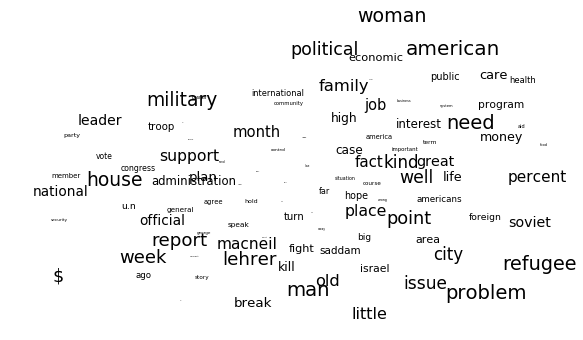

Period 1
[('camp', 0.9552030563354492), ('thousand', 0.9348312020301819), ('return', 0.9149553179740906), ('hundred', 0.9100853800773621), ('border', 0.8988558650016785), ('flee', 0.8963467478752136), ('rwanda', 0.8911385536193848), ('hutu', 0.8810654878616333), ('zaire', 0.870944619178772), ('ethnic', 0.8620430827140808)]
/embeddingplot already exisits


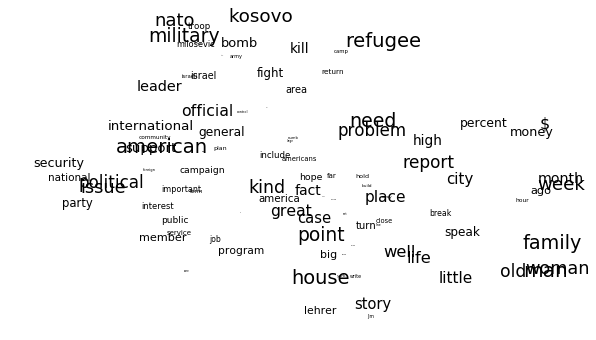

Period 2
[('internment', 0.8148714303970337), ('camp', 0.8025950193405151), ('flee', 0.7870465517044067), ('afghan', 0.7712109088897705), ('border', 0.7709745168685913), ('jenin', 0.7664477229118347), ('return', 0.7657953500747681), ('near', 0.7641355395317078), ('thousand', 0.7528505921363831), ('pakistan', 0.7525469064712524)]
/embeddingplot already exisits


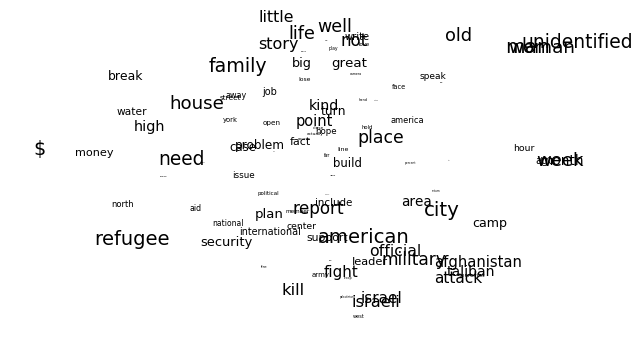

Period 3
[('border', 0.9747610092163086), ('camp', 0.9683483242988586), ('flee', 0.9669307470321655), ('iraqi', 0.9546638131141663), ('official', 0.952784538269043), ('attack', 0.9513914585113525), ('military', 0.9503369331359863), ('syria', 0.950169563293457), ('lebanon', 0.9475246667861938), ('southern', 0.9464201331138611)]
/embeddingplot already exisits


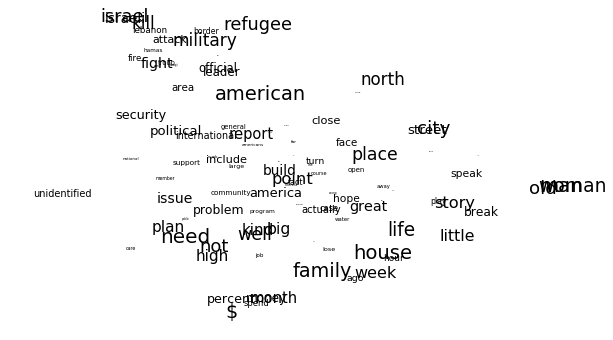

Period 4
[('camp', 0.9434390664100647), ('border', 0.9343764781951904), ('migrant', 0.9291478395462036), ('flee', 0.9208931922912598), ('thousand', 0.9082233905792236), ('europe', 0.8983216881752014), ('cross', 0.8926002979278564), ('turkey', 0.8861056566238403), ('lebanon', 0.8719570636749268), ('syrians', 0.869300127029419)]
/embeddingplot already exisits


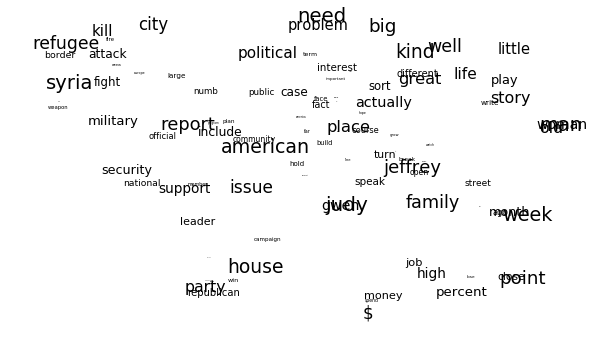

Period 0
[('family', 0.9999459981918335), ('leader', 0.999941349029541), ('man', 0.9999409317970276), ('political', 0.9999398589134216), ('old', 0.9999382495880127), ('house', 0.999936044216156), ('social', 0.999934196472168), ('america', 0.9999328255653381), ('american', 0.999932050704956), ('support', 0.9999259114265442)]
/embeddingplot already exisits


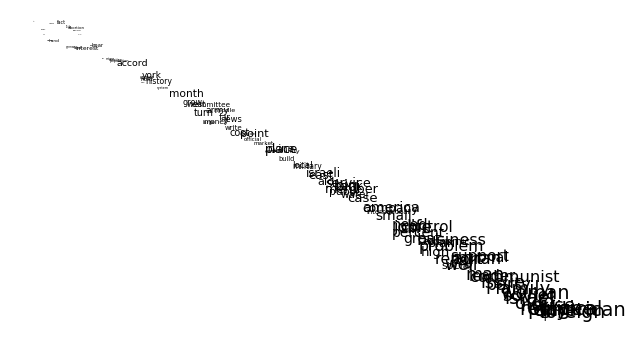

Period 1
[('america', 0.992660641670227), ('leader', 0.9916485548019409), ('american', 0.9908161759376526), ('include', 0.9906593561172485), ('man', 0.9903560876846313), ('family', 0.9903112649917603), ('political', 0.9900856018066406), ('international', 0.9900480508804321), ('kosovo', 0.9895071983337402), ('military', 0.9890062808990479)]
/embeddingplot already exisits


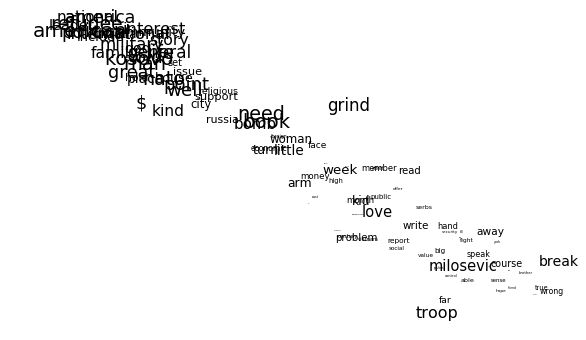

Period 2
[('america', 0.9975697994232178), ('family', 0.9971835613250732), ('american', 0.9970400333404541), ('military', 0.9970009326934814), ('colombia', 0.996976912021637), ('$', 0.9966460466384888), ('great', 0.9966075420379639), ('support', 0.996597409248352), ('religious', 0.9965674877166748), ('man', 0.9965674877166748)]
/embeddingplot already exisits


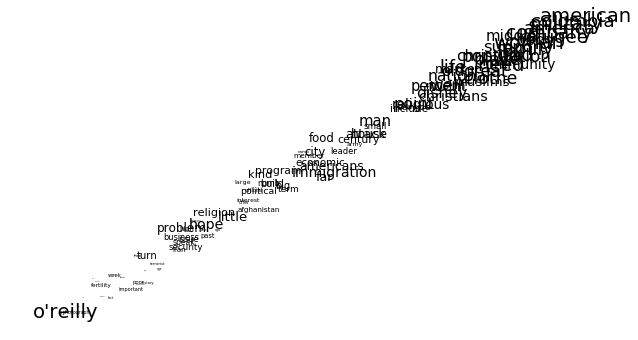

Period 3
[('family', 0.9757526516914368), ('man', 0.9751811027526855), ('leader', 0.9727336168289185), ('high', 0.9698243141174316), ('israel', 0.9693278670310974), ('include', 0.9691482186317444), ('american', 0.96909499168396), ('need', 0.9686713814735413), ('america', 0.9685633182525635), ('woman', 0.9674865007400513)]
/embeddingplot already exisits


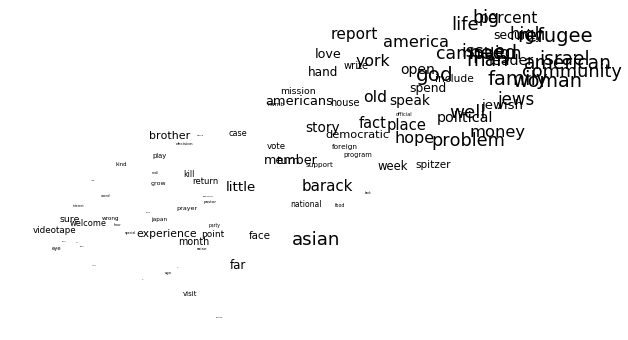

Period 4
[('include', 0.999943733215332), ('family', 0.9999377131462097), ('face', 0.9999340772628784), ('america', 0.9999337196350098), ('story', 0.9999311566352844), ('old', 0.9999294877052307), ('house', 0.9999291896820068), ('american', 0.9999287128448486), ('great', 0.99992835521698), ('catholic', 0.9999282956123352)]
/embeddingplot already exisits


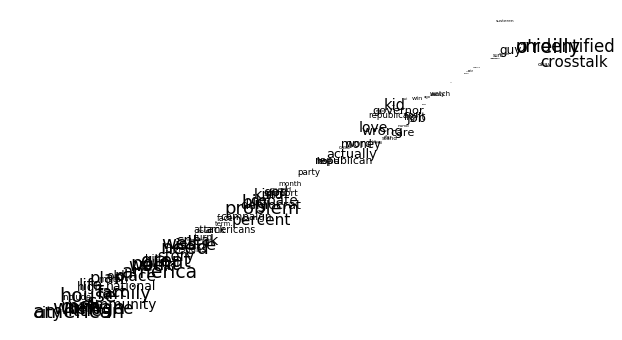

In [42]:
w2v_left = get_w2v(data_left)
w2v_right = get_w2v(data_right)

In [43]:
w2v_left

{0: <gensim.models.word2vec.Word2Vec at 0x13b22ad90>,
 1: <gensim.models.word2vec.Word2Vec at 0x27f318c10>,
 2: <gensim.models.word2vec.Word2Vec at 0x27f318430>,
 3: <gensim.models.word2vec.Word2Vec at 0x336c296d0>,
 4: <gensim.models.word2vec.Word2Vec at 0x1764bc790>}

In [44]:
w2v_right

{0: <gensim.models.word2vec.Word2Vec at 0x336c29af0>,
 1: <gensim.models.word2vec.Word2Vec at 0x336c29850>,
 2: <gensim.models.word2vec.Word2Vec at 0x175e43a00>,
 3: <gensim.models.word2vec.Word2Vec at 0x175ff8bb0>,
 4: <gensim.models.word2vec.Word2Vec at 0x17b32ad00>}

## 3. How are countries/identities associated with refugees over time?
* Countries: countrylist library
* Identities: citizenship (e.g. iraqi, chinese, etc.), religion, demographic (male, female, mother, father, child/children, etc.)
* Dimensions: legal-illegal, accept-ban, refugee-native

In [45]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

def makeDF(model, word_list, Dim1, Dim2, Dim3, dim1_label, dim2_label, dim3_label):
    dim1 = []
    dim2 = []
    dim3 = []
    for word in word_list:
        dim1.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim1.reshape(1,-1))[0][0])
        dim2.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim2.reshape(1,-1))[0][0])
        dim3.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Dim3.reshape(1,-1))[0][0])
    df = pd.DataFrame({dim1_label: dim1, dim2_label: dim2, dim3_label: dim3}, index = word_list)
    return df

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

In [46]:
def get_common_words(period_w2v):
    words = {}
    common = []

    for p in periods:
        vocab = list(period_w2v[p].wv.vocab.keys())
        for v in vocab:
            if v in words:
                words[v] += 1
            else:
                words[v] = 1
    for w, count in words.items():
        if count >= len(periods):
            # word in all periods
            common.append(w)
    return common

common_left = get_common_words(w2v_left)
common_right = get_common_words(w2v_right)
print(len(common_left), len(common_right))

5524 864


#### Country Analysis - Word Counts

In [47]:
from country_list import countries_for_language
countries = dict(countries_for_language('en'))
countrylist = list(c.lower() for c in countries.values())
countrylist_all = countrylist + ['soviet', 'palestine']

In [48]:
# Article counts over periods
# def get_word_count(data):
#     country_byperiod = {}
#     for p in periods:
#         for word in data[data['period']==p]['tokenized_words'].sum():
#             if word in countrylist_all:
#                 p=str(p)
#                 if p not in country_byperiod:
#                     country_byperiod[p] = {}
#                 if word not in country_byperiod[p]:
#                     country_byperiod[p][word] = 1
#                 else:
#                     country_byperiod[p][word] +=1
#     country_byperiod_df = pd.DataFrame.from_dict(country_byperiod, orient='index')
#     country_byperiod_df.dropna(axis='columns', how='all', inplace=True)
#     return country_byperiod_df

def get_country_counts(data):
    country_byperiod = {}
    for p in periods:
        for word in countrylist_all:
            # get number of articles that a country appears
            count = len(data[data['period']==p].where(data['text'].str.contains(r'\b{}\b'.format(word))).dropna())
            if p not in country_byperiod:
                country_byperiod[p] = {}
            country_byperiod[p][word] = count
    country_byperiod_df = pd.DataFrame.from_dict(country_byperiod, orient='index')
    country_byperiod_df.dropna(axis='columns', how='all', inplace=True)
    return country_byperiod_df

In [49]:
countrycounts_left = get_country_counts(data_left)

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [50]:
countrycounts_left['total'] = [len(data[data['period']==i])for i in countrycounts_left.index]
countrycounts_leftpc = countrycounts_left.apply(lambda x: x/countrycounts_left['total'])
countrycounts_leftpc.drop(columns=['total','united states'], inplace=True)

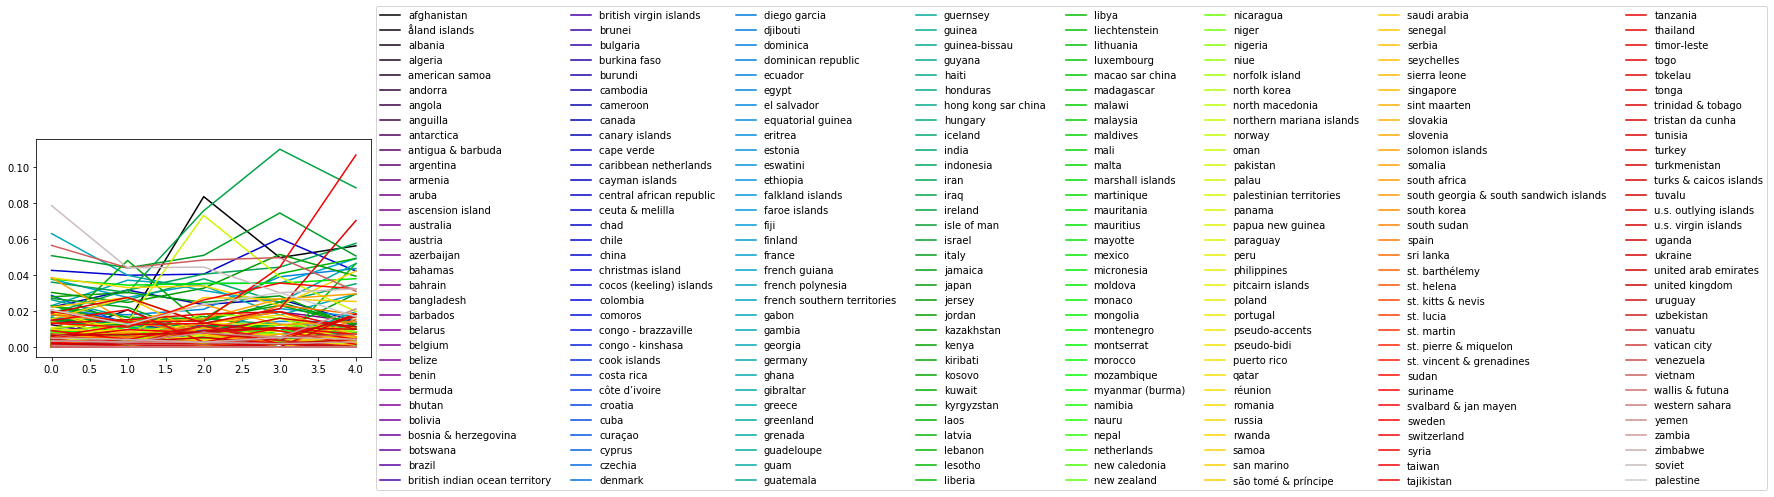

In [51]:
countrycounts_leftpc.plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=8)

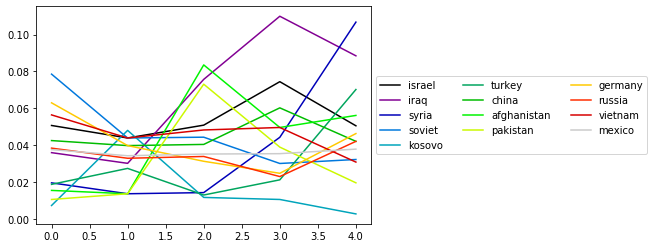

In [52]:
selected = ['israel','iraq','syria','soviet','kosovo','turkey','china','afghanistan',
          'pakistan','germany','russia','vietnam','mexico']
countrycounts_leftpc[selected].plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=3)

In [53]:
countrycounts_right = get_country_counts(data_right)
countrycounts_right['total'] = [len(data[data['period']==i])for i in countrycounts_right.index]
countrycounts_rightpc = countrycounts_right.apply(lambda x: x/countrycounts_right['total'])
countrycounts_rightpc.drop(columns=['total','united states'], inplace=True)

/Users/rachelker/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


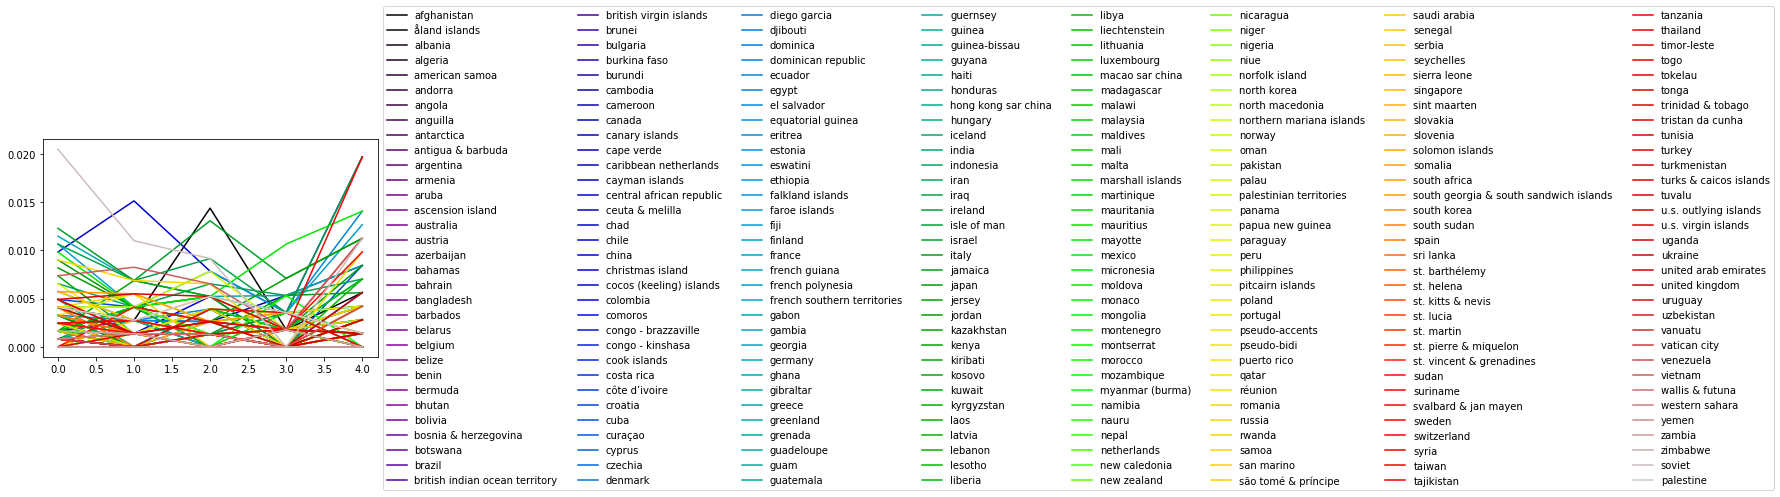

In [54]:
countrycounts_rightpc.plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=8)

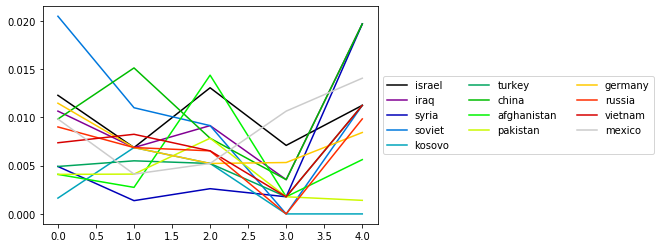

In [55]:
selected=['israel','iraq','syria','soviet','kosovo','turkey','china','afghanistan',
          'pakistan','germany','russia','vietnam','mexico']
countrycounts_rightpc[selected].plot(colormap='nipy_spectral')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=3)

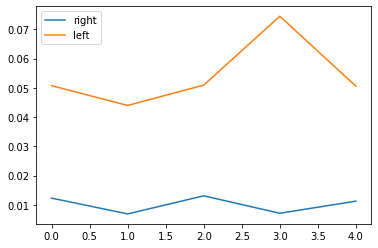

In [56]:
israel_df = pd.DataFrame({'right': list(countrycounts_rightpc['israel']), 
                          'left': list(countrycounts_leftpc['israel'])})
israel_df.plot()

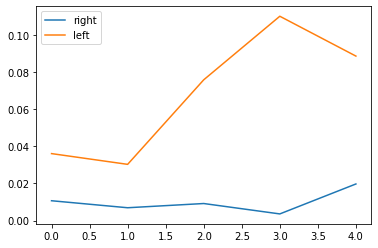

In [57]:
iraq_df = pd.DataFrame({'right': list(countrycounts_rightpc['iraq']), 
                        'left': list(countrycounts_leftpc['iraq'])})
iraq_df.plot()

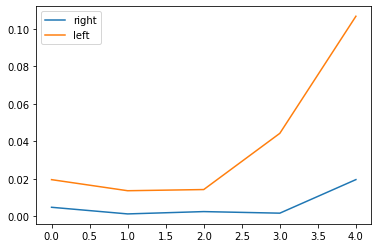

In [58]:
syria_df = pd.DataFrame({'right': list(countrycounts_rightpc['syria']), 
                          'left': list(countrycounts_leftpc['syria'])})
syria_df.plot()

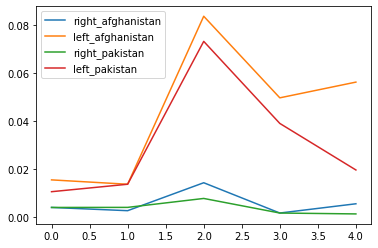

In [59]:
afghan_pakistan_df = pd.DataFrame({'right_afghanistan': list(countrycounts_rightpc['afghanistan']), 
                                   'left_afghanistan': list(countrycounts_leftpc['afghanistan']),
                                   'right_pakistan': list(countrycounts_rightpc['pakistan']),
                                   'left_pakistan': list(countrycounts_leftpc['pakistan']),
                                  })
afghan_pakistan_df.plot()

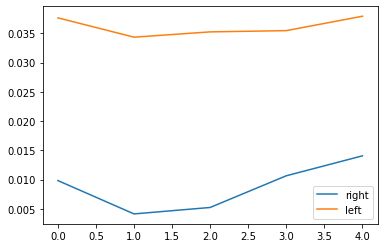

In [60]:
mexico_df = pd.DataFrame({'right': list(countrycounts_rightpc['mexico']), 
                          'left': list(countrycounts_leftpc['mexico'])})
mexico_df.plot()

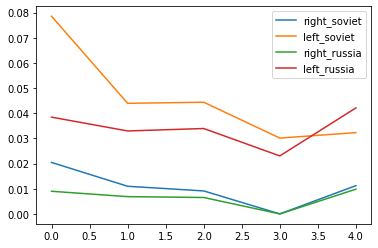

In [61]:
soviet_df = pd.DataFrame({'right_soviet': list(countrycounts_rightpc['soviet']), 
                          'left_soviet': list(countrycounts_leftpc['soviet']),
                          'right_russia': list(countrycounts_rightpc['russia']), 
                          'left_russia': list(countrycounts_leftpc['russia'])
                         })
soviet_df.plot()

#### Country Analysis - W2V dimensions

In [62]:
def plot_dimensions(w2v, countries_full):
    for p in periods:
        model = w2v[p]
        Refugee = dimension(model, ['refugee','flee'], ['citizen','remain'])
        Accept = dimension(model, ['welcome', 'accept'], ['ban','reject'])
        Legal = dimension(model, ['legal'], ['illegal'])
        df = makeDF(model, countries_full, Refugee, Accept, Legal, 'refugee', 'accept', 'legal') 
        fig = plt.figure(figsize = (12,4))
        ax1 = fig.add_subplot(131)
        PlotDimension(ax1, df, 'refugee')
        ax2 = fig.add_subplot(132)
        PlotDimension(ax2, df, 'accept')
        ax3 = fig.add_subplot(133)
        PlotDimension(ax3, df, 'legal')
        plt.show

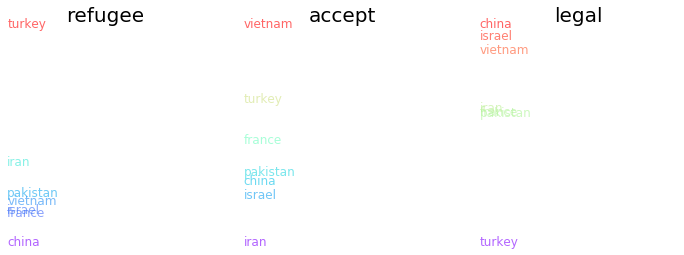

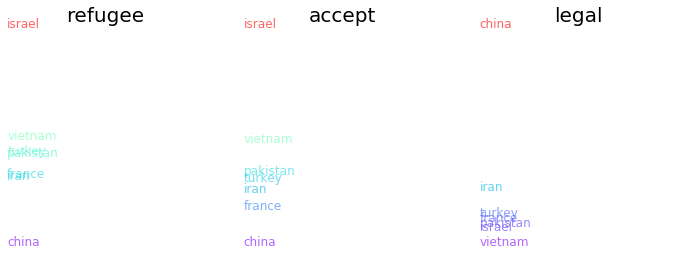

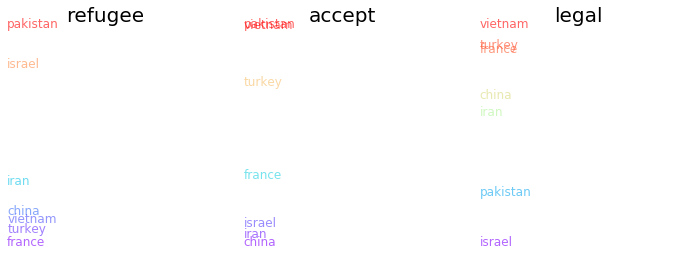

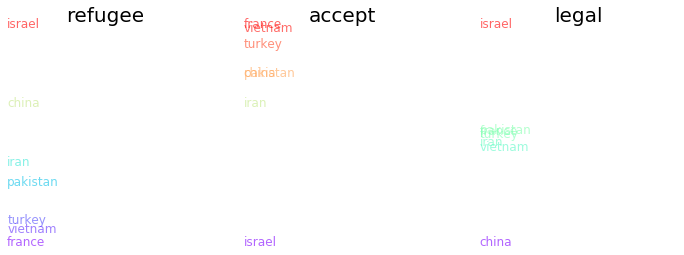

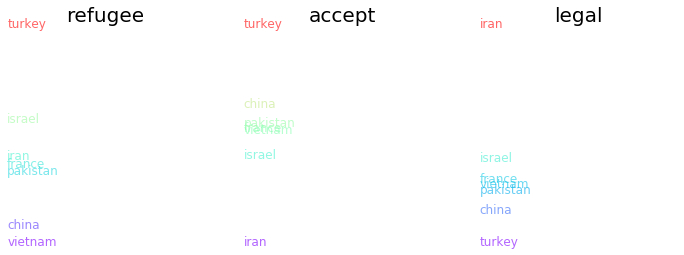

In [63]:
# W2V Dimensions for Countries
countries_w2v = []
for country in countrylist:
    if (country in common_left) & (country in common_right):
        countries_w2v.append(country.lower())
        
countries_full = countries_w2v
plot_dimensions(w2v_left, countries_full)

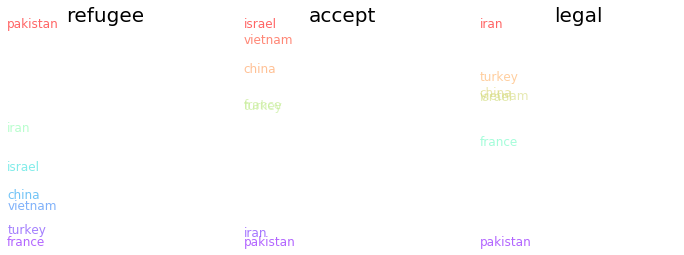

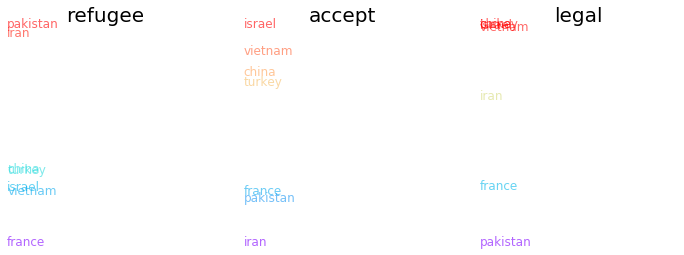

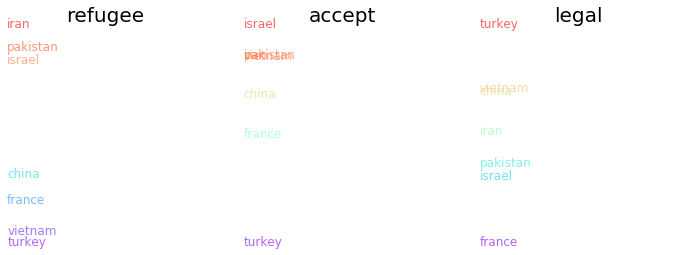

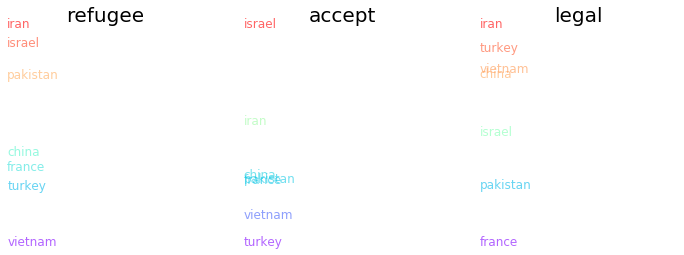

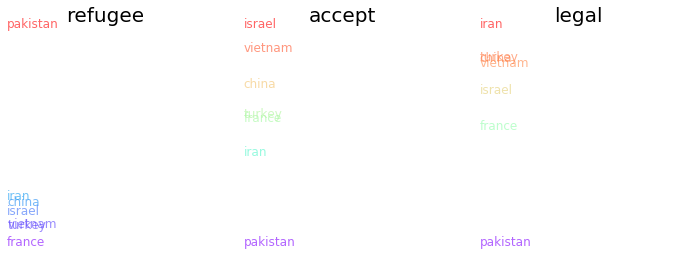

In [64]:
plot_dimensions(w2v_right, countries_full)

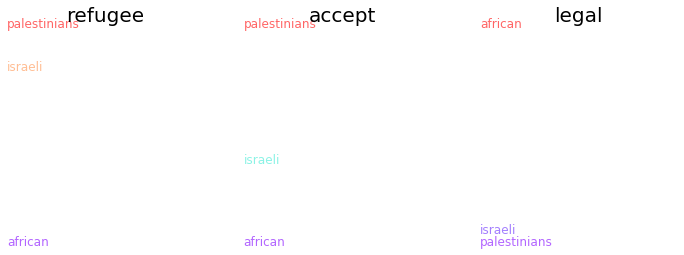

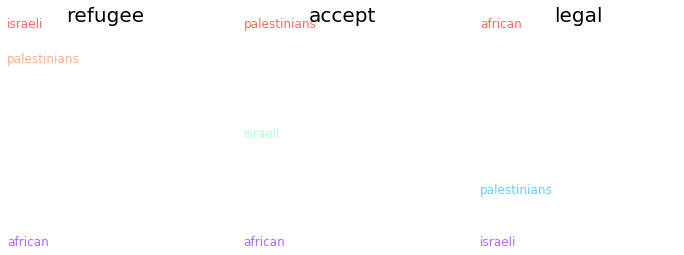

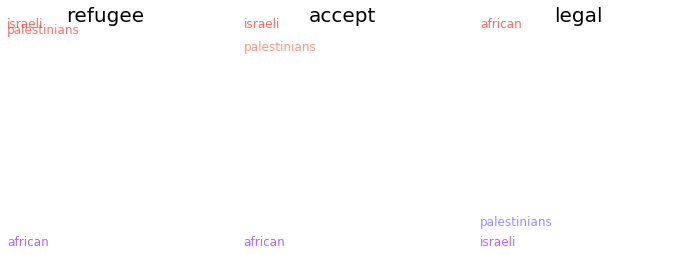

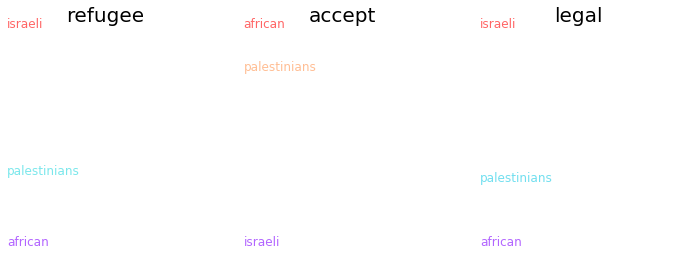

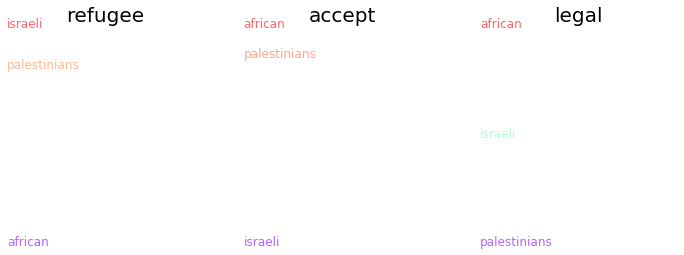

In [65]:
# W2V Dimensions for Citizenship
citizenship=['israeli','palestinians','african']

plot_dimensions(w2v_left, citizenship)

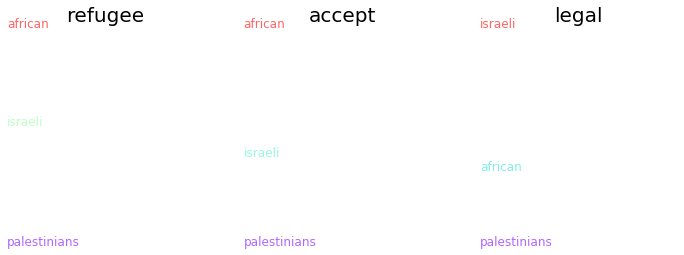

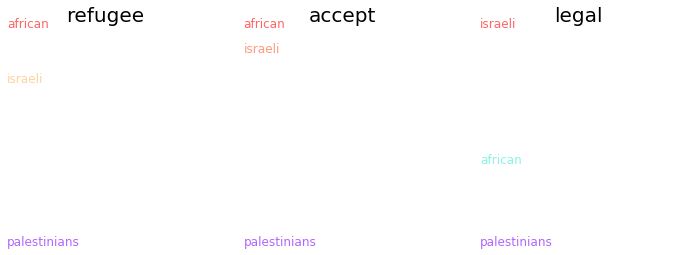

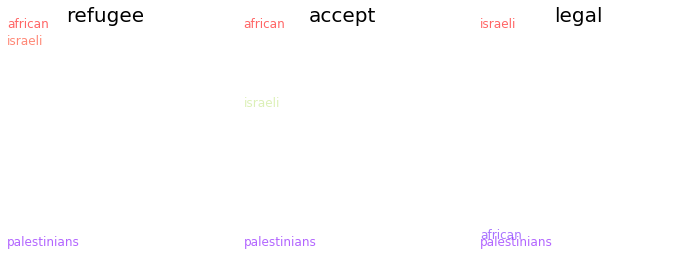

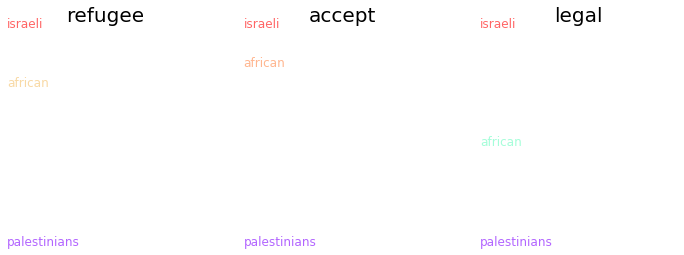

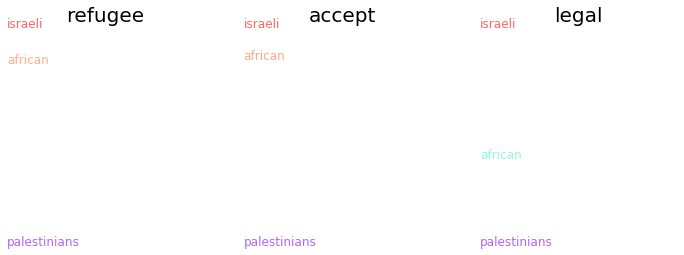

In [66]:
plot_dimensions(w2v_right, citizenship)

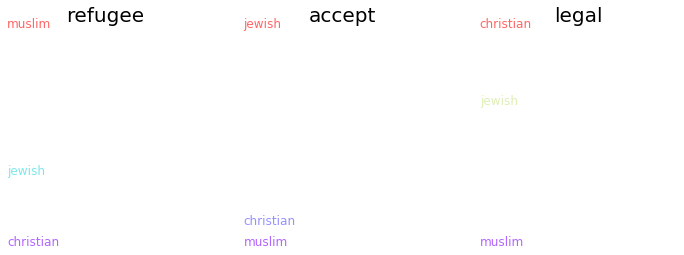

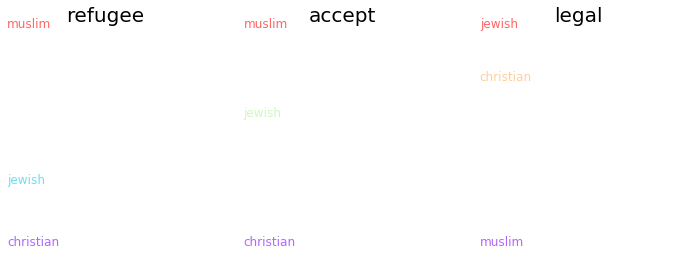

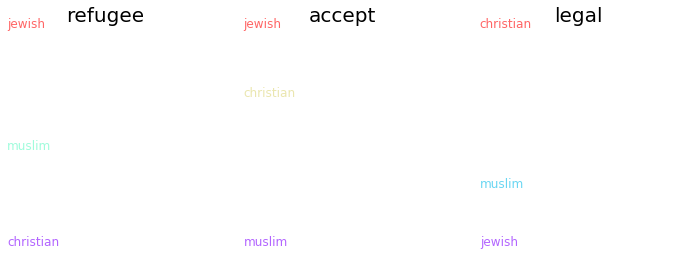

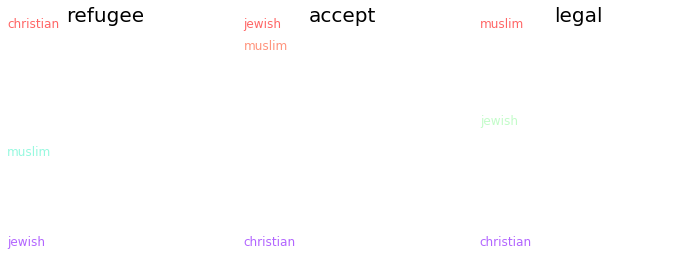

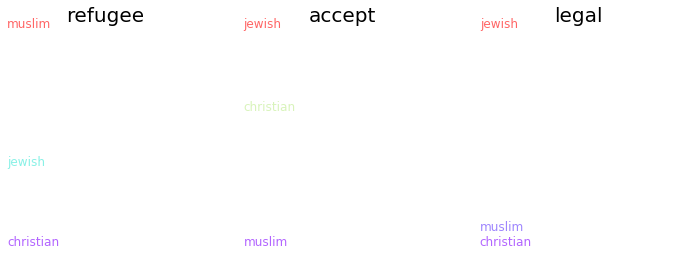

In [67]:
# W2V Dimensions for Religion
religion = ['christian', 'muslim', 'jewish']
plot_dimensions(w2v_left, religion)

KeyError: "word 'muslim' not in vocabulary"

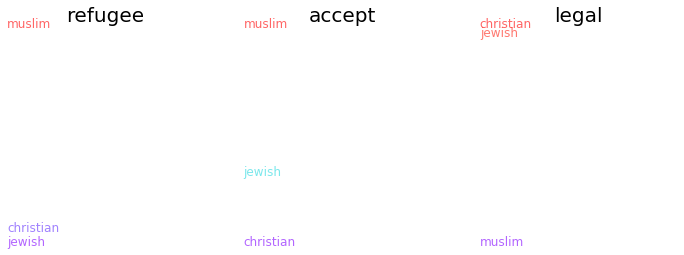

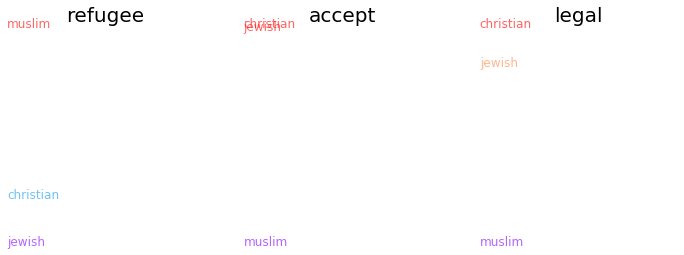

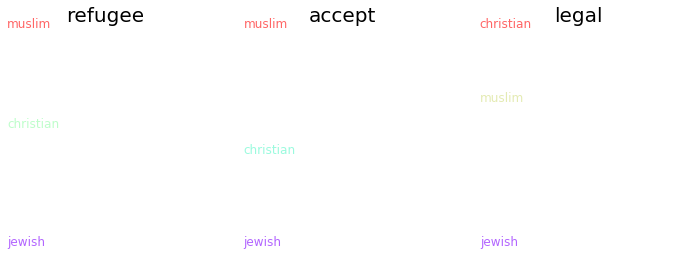

In [68]:
plot_dimensions(w2v_right, religion)

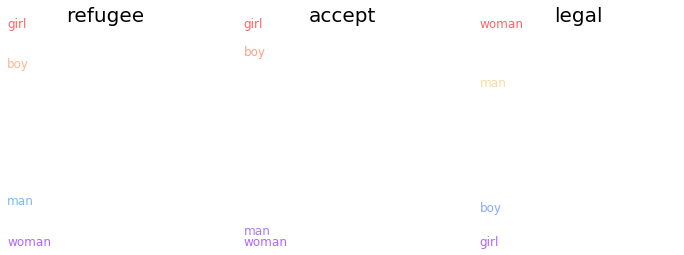

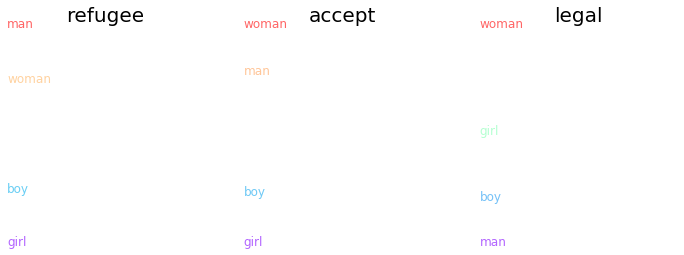

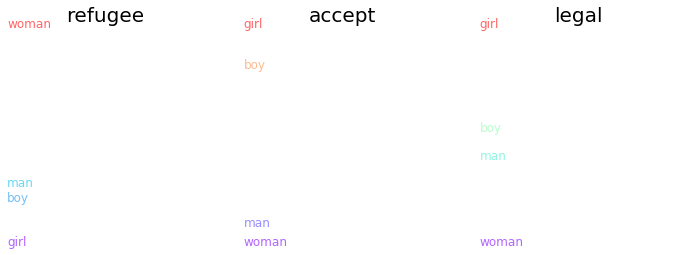

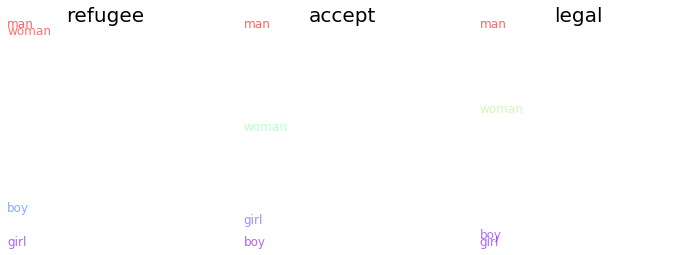

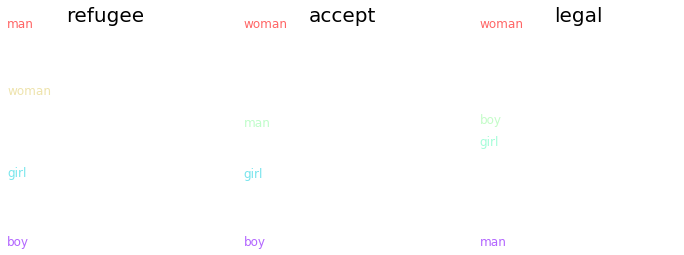

In [69]:
# W2V Dimensions for Demographic
demographic=['man', 'woman', 'girl', 'boy']
plot_dimensions(w2v_left, demographic)

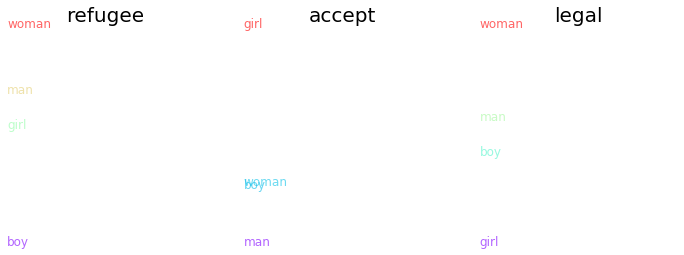

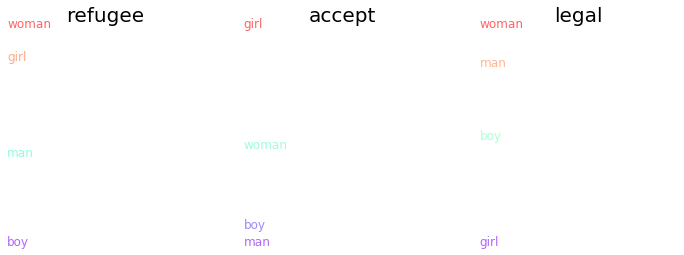

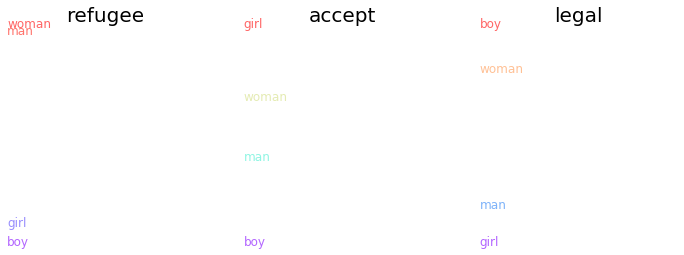

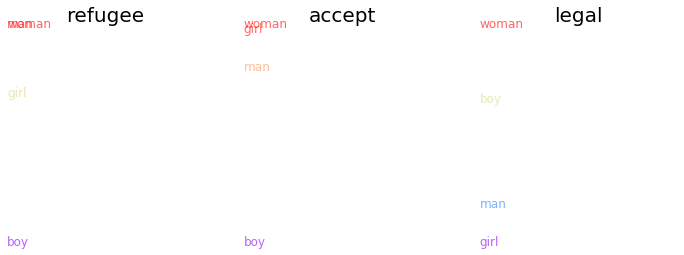

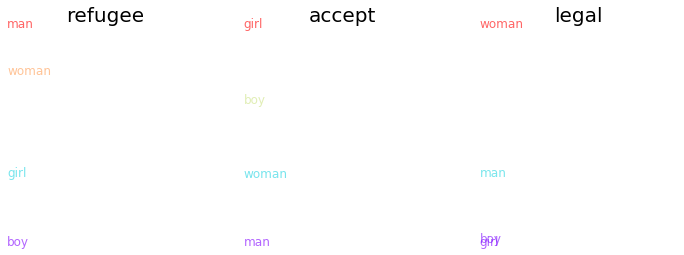

In [70]:
plot_dimensions(w2v_right, demographic)